In [32]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz



In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [261]:
df = pd.read_csv('./input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())


   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [262]:
df.shape

(6362620, 11)

In [35]:
df.isnull().values.any()


False

In [36]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]


# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)


In [37]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))



The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [38]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1


In [39]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan


In [40]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest


In [41]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

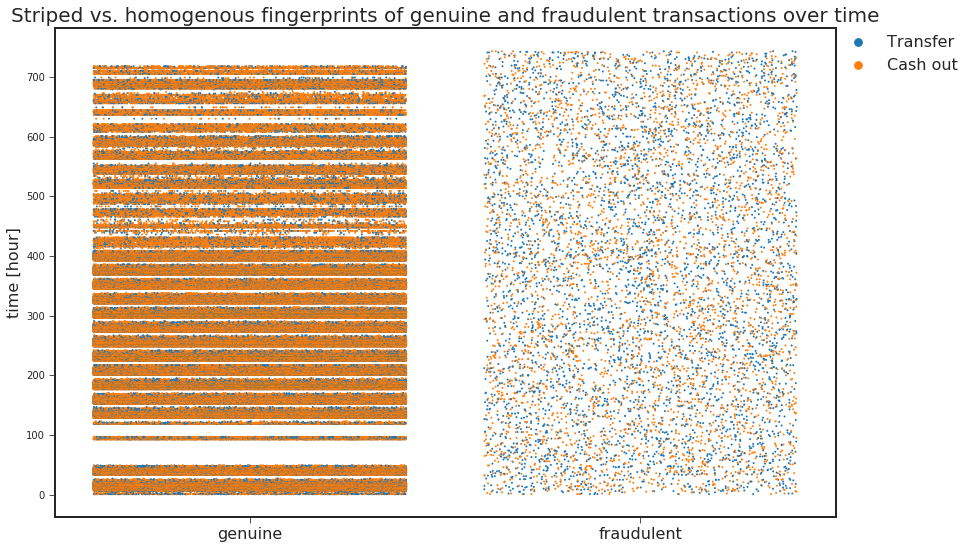

In [42]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);


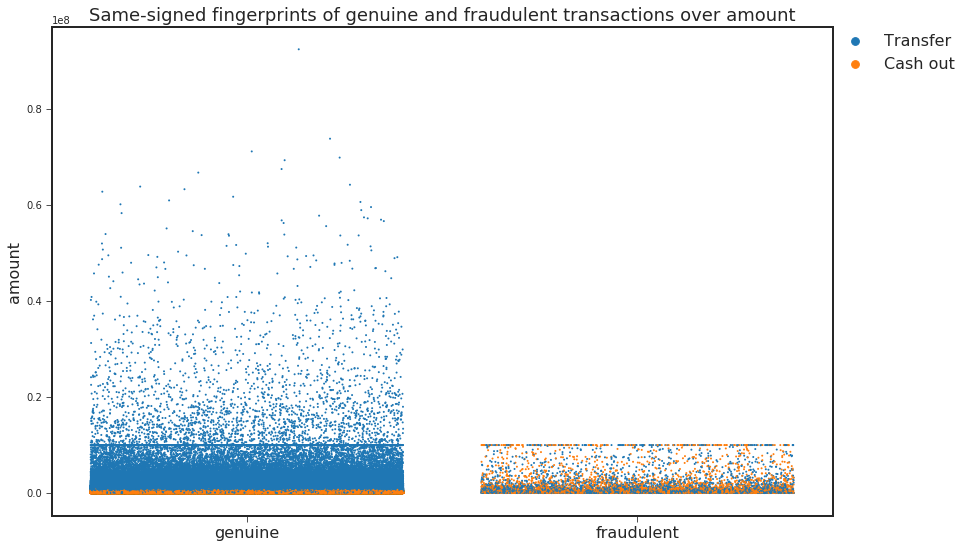

In [43]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);


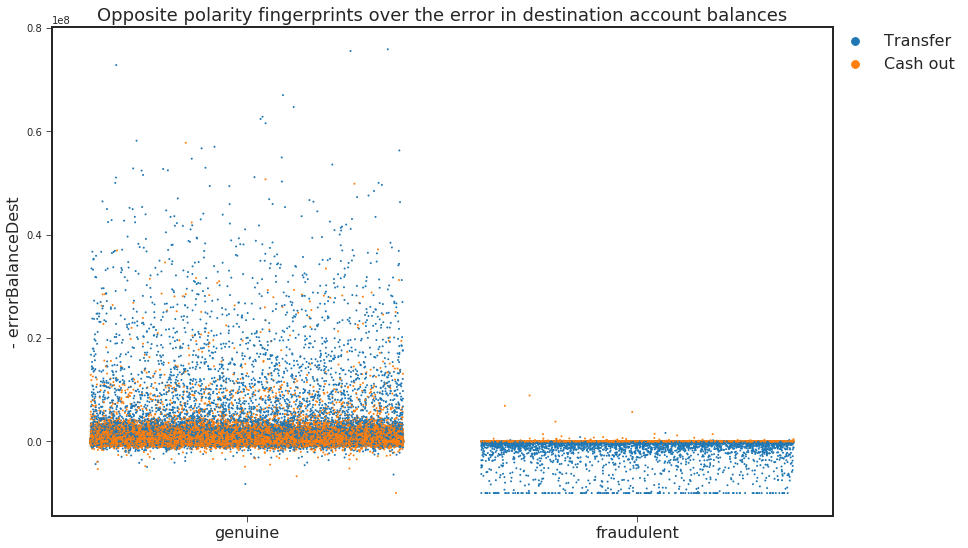

In [44]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);


In [45]:
X.describe()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
count,2.770409e+06,2.770409e+06,2.770409e+06,1.461843e+06,1.461843e+06,2.770409e+06,2.770409e+06,2.770409e+06,1.461843e+06,2.770409e+06
mean,2.420081e+02,8.076425e-01,3.175361e+05,9.029069e+04,3.049654e+04,1.703551e+06,2.049734e+06,2.964544e-03,2.433588e+05,-2.864713e+04
std,1.416191e+02,3.941525e-01,8.877897e+05,3.403749e+05,2.071679e+05,4.225550e+06,4.676990e+06,5.436687e-02,6.337355e+05,5.934794e+05
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e-02,-7.588573e+07
25%,1.550000e+02,1.000000e+00,8.297354e+04,1.034300e+04,0.000000e+00,1.280734e+05,3.272891e+05,0.000000e+00,2.127810e+04,0.000000e+00
50%,2.360000e+02,1.000000e+00,1.712609e+05,2.918300e+04,0.000000e+00,5.557100e+05,8.280539e+05,0.000000e+00,1.180161e+05,0.000000e+00
75%,3.320000e+02,1.000000e+00,3.067912e+05,8.862500e+04,0.000000e+00,1.735900e+06,2.122198e+06,0.000000e+00,2.546194e+05,0.000000e+00
max,7.430000e+02,1.000000e+00,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,5.774557e+07,1.000000e+07


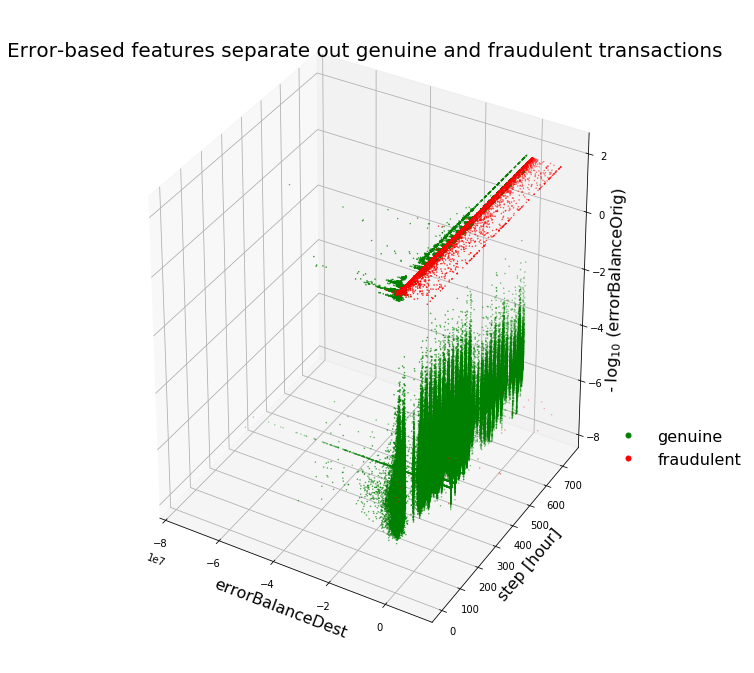

In [14]:
# Long computation in this cell (~2.5 minutes)







x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

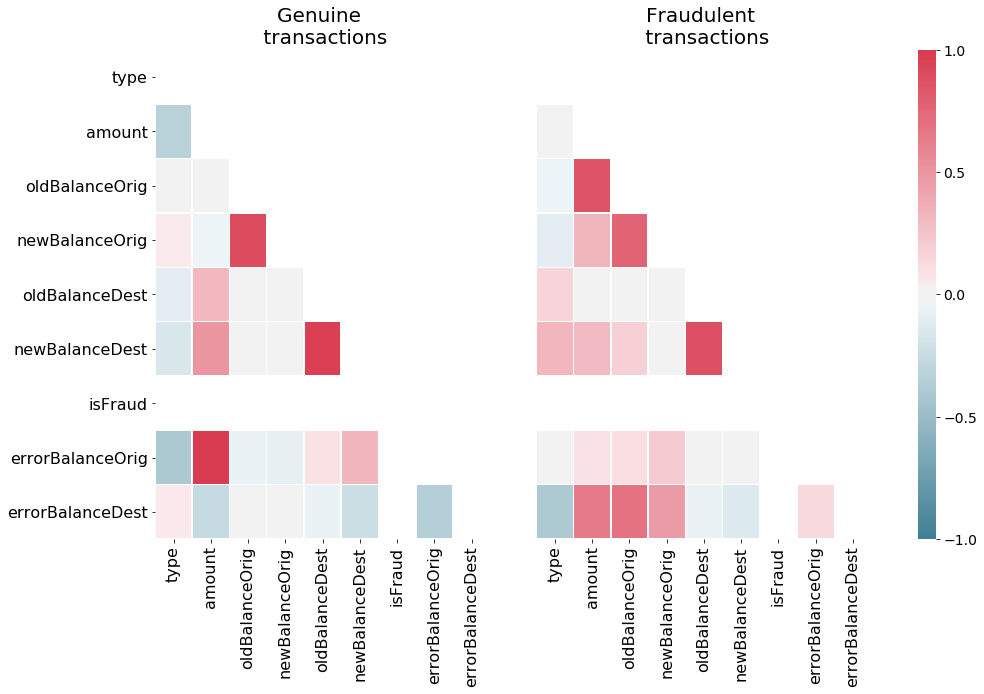

In [46]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);


In [15]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)


In [16]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))


AUPRC = 0.9986361116985445


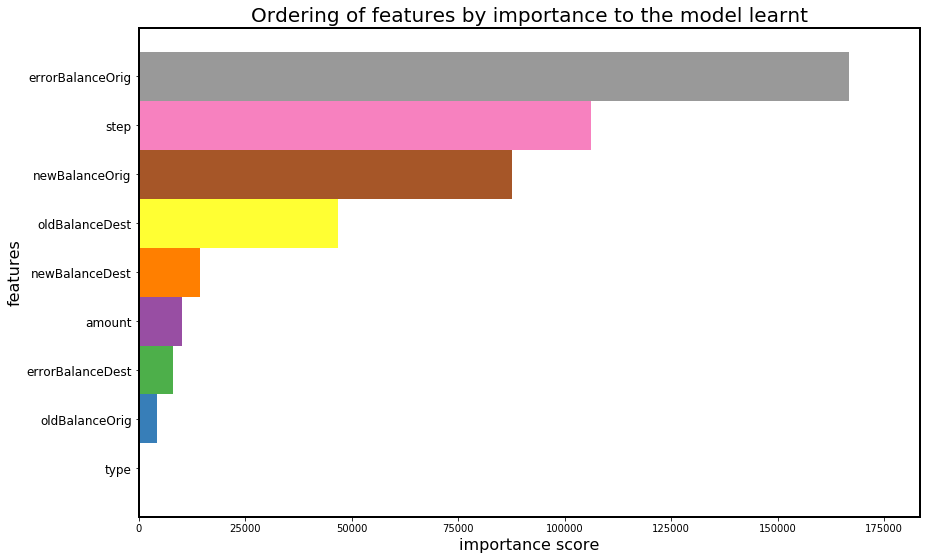

In [17]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);


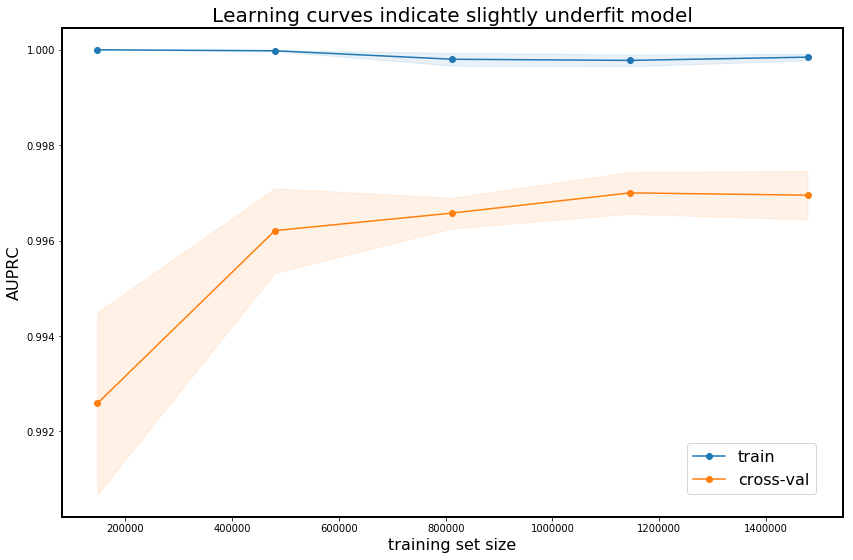

In [21]:

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

In [22]:
from sklearn.externals import joblib
joblib.dump(clf, 'filename.pkl') 

['filename.pkl']

In [23]:
import pickle


list_pickle_path = 'pickle.pkl'


list_pickle = open(list_pickle_path, 'wb')
pickle.dump(clf, list_pickle)
list_pickle.close()

In [ ]:
Y = X['isFraud']
del X['isFraud']

In [24]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [26]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

In [91]:
z = X.iloc[0:1]

In [93]:
z

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.0,181.0,0.0,-1.0,-1.0,0.0,181.0


In [95]:
import numpy
z = numpy.array(z).reshape((1,-1))

In [ ]:
'''
Step: Number of hours elapsed
Amount: Transaction Amount

oldBalanceOrig: Normalized Old Transactions (Last Reciept)
newBalanceOrig: Balance after the Transaction (New Reciept)

oldBalanceDest: Average last transactions(10)
newBalanceDest: Average last transactions(5)

errorBalanceOrig: Differnce of ordered and retured
'''

In [48]:
X

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.00,0.00,-1.00,-1.00,1,0.000000e+00,1.810000e+02
3,1,1,181.00,181.00,0.00,21182.00,0.00,1,0.000000e+00,2.136300e+04
15,1,1,229133.94,15325.00,0.00,5083.00,51513.44,0,2.138089e+05,1.827035e+05
19,1,0,215310.30,705.00,0.00,22425.00,0.00,0,2.146053e+05,2.377353e+05
24,1,0,311685.89,10835.00,0.00,6267.00,2719172.89,0,3.008509e+05,-2.401220e+06
42,1,1,110414.71,26845.41,0.00,288800.00,2415.16,0,8.356930e+04,3.967996e+05
47,1,1,56953.90,1942.02,0.00,70253.00,64106.18,0,5.501188e+04,6.310072e+04
48,1,1,5346.89,NaN,NaN,652637.00,6453430.91,0,NaN,-5.795447e+06
51,1,1,23261.30,20411.53,0.00,25742.00,0.00,0,2.849770e+03,4.900330e+04
58,1,0,62610.80,79114.00,16503.20,517.00,8383.29,0,0.000000e+00,5.474451e+04


In [60]:
X[(X['amount'] > 1000) & (X['type'] == False)]

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
19,1,0,215310.30,705.00,0.00,22425.00,0.00,0,214605.30,237735.30
24,1,0,311685.89,10835.00,0.00,6267.00,2719172.89,0,300850.89,-2401220.00
58,1,0,62610.80,79114.00,16503.20,517.00,8383.29,0,0.00,54744.51
78,1,0,42712.39,10363.39,0.00,57901.66,24044.18,0,32349.00,76569.87
79,1,0,77957.68,NaN,NaN,94900.00,22233.65,0,NaN,150624.03
80,1,0,17231.46,NaN,NaN,24672.00,0.00,0,NaN,41903.46
81,1,0,78766.03,NaN,NaN,103772.00,277515.05,0,NaN,-94977.02
82,1,0,224606.64,NaN,NaN,354678.92,0.00,0,NaN,579285.56
83,1,0,125872.53,NaN,NaN,348512.00,3420103.09,0,NaN,-2945718.56
84,1,0,379856.23,NaN,NaN,900180.00,19169204.93,0,NaN,-17889168.70


In [29]:
Y[4837753]

0

In [61]:
X.to_pickle('dataset.pkl') 

In [63]:
Z = pd.read_pickle('dataset.pkl')

In [151]:
def get_data(amount, fraud):
    df = Z[((Z['amount'] > amount-500) & (Z['amount'] < amount+500)) & (Z['isFraud'] == fraud)].head()
    return df

In [172]:
for i in get_data(1000, 0).iloc[0]:
    print(i)

1.0
1.0
1341.58
nan
nan
80341.0
557537.26
0.0
nan
-475854.68


In [177]:
samp = get_data(1000,1).sample()

In [178]:
del samp['isFraud']

In [179]:
model.predict(samp)

array([1])

In [113]:
import pickle
model = pickle.load(open("../flask-basic-ecommerce/model/pickle.pkl", "rb"))

In [92]:
def predict(amount):
    cols = ['step', 'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
        'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest']
    a = [742,1,amount,54652.46,0.00,0.00,54652.46,0.000000e+00,0.000000e+00]
    my_df  = pd.DataFrame([a], columns = cols)
    return model.predict(my_df)[0]


In [93]:
predict(1000)

1

In [102]:
X.shape

(2770409, 10)

In [259]:
amount = [100,1000,10000,100000,1000000]
fraud = [0,1]
for i in amount:
    for j in fraud:
        print(Z[((Z['amount'] > i-500) & (Z['amount'] < i+500)) & (Z['isFraud'] == j)].head())
        print("\n\n\n------------------\n\n\n")

       step  type  amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  \
1103      1     1  593.40             NaN             NaN       149933.66   
6413      6     1   71.29             NaN             NaN        46393.85   
13337     7     1  135.29             NaN             NaN       312111.34   
15359     8     1  281.81             NaN             NaN        14931.69   
18047     8     1  366.60             NaN             NaN      2127642.79   

       newBalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  
1103         46393.85        0               NaN         104133.21  
6413         46465.14        0               NaN              0.00  
13337       963198.49        0               NaN        -650951.86  
15359       449233.66        0               NaN        -434020.16  
18047      4743010.67        0               NaN       -2615001.28  



------------------



       step  type  amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  \
2         1     0   1